In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#MT: Maraud travel (travel to rival's bower)
#MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)
#MR: Maraud return (return to own bower)
#RB: Repair own bower
#MT_vs_FG: the probability of next transition away from SB being to MT (otherwise it would be to FG)
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#a=-4: denotes travel to another male's bower
#a=-5: denotes marauding of another male's bower
#a=-6: denotes returning from another male's bower
#a=-7: denotes a bower repair action on a ticket
#targ: denotes travel, maurading action, and return from said target's bower
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are 1 (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network
#node_dist: the node by nde matrix with distances between each node
#node_graph: matrix with individuals 1 through nodes numbered by going through each row




import math
import random
import numpy as numpy
import matplotlib.pyplot as plt


#Parameters:
t=0.0 #start at time 0
t_max=12#*4*30 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder=0
timeline=[] #initialize the timeline
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=[1, t_max/2] #5days, tmax/3 #0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
RB_param=.5 #made up -- takes 30mins (every time -- no distribution) to repair bower
MA_param=.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower
MT_vs_FG=.05 #compared 20 feedings/day to .1 maraudings/hr
nodes=4
bower_states=[1]*nodes
male_states=[1]*nodes
fitness_states=[0]*nodes
success_rates=1
success_times=[]
recents_list=[]
max_visits=6 #STEEEEVEEEE
bird_speed=12*3600 #m/hr (12m/s)
d=150.0




# makes a ticket
def ticketgenerator(tau,t, o, a, targ):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
        'target': targ
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
            -5: MA_param, #in the future we'll do something with it
            -7: RB_param #in the future we'll do something with it 
        }
        x=switcher.get(action)
    return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
    
def SBtickethandler(SB_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times):
    ow=SB_tic['owner'] 
    if male_states[ow]==1: #because any male who is at his bower was last repairing his bower (not coming from FG or MR) 
        bower_states[ow]=1
    male_states[ow]=1
    t=SB_tic['time']
    ta=SB_tic['tau']
    if bower_states[ow]==0: #if male returns to a destroyed bower, must repair it
        RB_tau=nexttau(-7)
        SB_tic['tau']=0
        RB_tic=ticketgenerator(RB_tau,t,ow,-7,ow) #immediately, RB_tic starts 
        addtotimeline(RB_tic, timeline)
    else:
        MT_FG_time=ta+t
        if MT_FG_time<t_max:
            decider=random.random()
            if decider<MT_vs_FG: #if transition to MT
                targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[ow]) #choosing the male to maurad based on visit preferences
                MT_tau=travel_times[ow][targ]
                MT_tic=ticketgenerator(MT_tau,MT_FG_time,ow,-4, targ)
                addtotimeline(MT_tic, timeline)
            else:
                FG_tau=nexttau(-2)
                FG_tic=ticketgenerator(FG_tau,MT_FG_time,ow,-2, ow) #-2 denotes foraging action
                addtotimeline(FG_tic,timeline)

def FGtickethandler(FG_tic, timeline, t_max, male_states):
    ow=FG_tic['owner'] 
    male_states[ow]=0
    t=FG_tic['time']
    ta=FG_tic['tau']
    SB_time=t+ta
    SB_tau=nexttau(-2)
    if SB_time<t_max:
        SB_tic=ticketgenerator(SB_tau,SB_time,ow,-1, ow) #-1 denotes staying at bower
        addtotimeline(SB_tic,timeline)
        
def MTtickethandler(MT_tic,timeline,t_max,male_states):
    ow=MT_tic['owner']
    male_states[ow]=0 #male is no longer at his bower
    targ=MT_tic['target']
    t=MT_tic['time']
    ta=MT_tic['tau']
    MA_time=t+ta
    if MA_time<t_max:
        MA_tau=nexttau(-5)
        MA_tic=ticketgenerator(MA_tau,MA_time, ow, -5, targ) #generate a maurading action ticket
        addtotimeline(MA_tic, timeline)
            
def MAtickethandler(MA_tic, timeline, t_max, male_states, bower_states, travel_times):
    ow=MA_tic['owner'] 
    targ=MA_tic['target']
    if male_states[targ]==0 and bower_states[targ]==1: #if the bower is intact and its owner is absent
        bower_states[targ]=0
    else: #in all other cases bowerbird immediately leaves
        MA_tic['tau']=0 #COMMENT! Changing tau for this ticket as we read it bc stay is cut short by bower owner's presence
    t=MA_tic['time']
    ta=MA_tic['tau']
    MR_time=t+ta
    if MR_time<t_max:
        MR_tau=travel_times[ow][targ]
        MR_tic=ticketgenerator(MR_tau,MR_time, ow, -6, targ)
        addtotimeline(MR_tic, timeline)

            
def MRtickethandler(MR_tic,timeline,t_max):
    ow=MR_tic['owner']
    targ=MR_tic['target'] #accesing the male the owner chose to maurad based on visit preferences
    t=MR_tic['time']
    ta=MR_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        SB_tic=ticketgenerator(SB_tau,SB_time, ow, -1, ow) #generate stay at bower ticket
        addtotimeline(SB_tic, timeline)
            
def RBtickethandler(RB_tic, timeline, t_max):
    ow=RB_tic['owner']
    t=RB_tic['time']
    ta=RB_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        SB_tic=ticketgenerator(SB_tau, SB_time, ow, -1, ow)
        addtotimeline(SB_tic, timeline)
    
def FVtickethandler(FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rate, success_times, recents_list, max_visits):
    targ=FV_tic['target']
    ow=FV_tic['owner']
    t=FV_tic['time']
    recents_list=d["rl{0}".format(ow)]
    r=random.random()
    if bower_states[targ]==1 and male_states[targ]==1 and r<success_rate: #if the bower is intact and the male is present
        recents_list=[]
        fitness_states[targ]=fitness_states[targ]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t)
        new_FV_targ=numpy.random.choice(list(range(nodes)))
        decider=random.random() #decide whether female will mate for a second time
        if decider<.8: #half the time she'll mate again due to predation (or for the heck of it -- PJ said 4-5 matings)
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)        
    else: #if female does not successfully mate
        recents_list.append(targ)
        if len(recents_list)==min(max_visits, nodes): 
            recents_list=[]
            print(recents_list)
            new_FV_targ=numpy.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
        else:
            new_FV_targ=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_targ in recents_list or new_FV_targ==-1):
                new_FV_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[targ][new_FV_targ] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
    return recents_list



    
    
    
#FOR LATER
#def MTtickethandler (MT_tic, timeline, )

#distance function
def travel(nodes,d,bird_speed):
    node_dist= numpy.array([[-1.0]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
    sqrt_nodes=int(math.sqrt(nodes)) 
    node_graph=numpy.arange(nodes)
    node_mat=node_graph.reshape(sqrt_nodes,sqrt_nodes)
    for i in range(sqrt_nodes):
        for j in range (sqrt_nodes):
            n1=node_mat[i][j]
            for a in range(sqrt_nodes):
                for b in range(sqrt_nodes):
                    n2=node_mat[a][b]
                    if n1<n2:
                        d12=math.hypot((i-a)*d,abs(j-b)*d)
                        node_dist[n1][n2]=d12
                        node_dist[n2][n1]=d12
                    if n1==n2:
                        node_dist[n1][n2]=0
    travel_times=numpy.array([[0.0]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            travel_times[i][j]=node_dist[i][j]/bird_speed
    return [node_dist,travel_times, node_mat]





travel_mats=travel(nodes,d,bird_speed)
node_dist=travel_mats[0]
travel_times=travel_mats[1]
print(travel_mats[0].astype(int))
print(travel_mats[1])
print(travel_times)




#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def female_probs(node_dist, nodes, lamb):
    visit_preferences=numpy.array([[0.]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            if i!=j:
                visit_preferences[i][j]=math.exp(-lamb*node_dist[i][j])        
        visit_preferences[i]=visit_preferences[i]/sum(visit_preferences[i])
    return visit_preferences

visit_preferences=female_probs(travel_times, nodes, lamb)
#print(visit_preferences)
#print(visit_preferences[1])
print(nodes)
print(visit_preferences)

[[  0 150 150 212]
 [150   0 212 150]
 [150 212   0 150]
 [212 150 150   0]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
4
[[0.         0.33333425 0.33333425 0.33333149]
 [0.33333425 0.         0.33333149 0.33333425]
 [0.33333425 0.33333149 0.         0.33333425]
 [0.33333149 0.33333425 0.33333425 0.        ]]


In [2]:
#just a test

d={}
 
#the logic with ts and taus is not parallel to all other ticket types, but it seems to work... maybe change later    
for i in range(int(3*nodes)): 
    first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
    first_female_time=t+nexttau(-3) #determine the time when the first female arrives
    first_female_tic=ticketgenerator(first_female_time-t,first_female_time, i, -3, first_male) #first female ticket
    addtotimeline(first_female_tic, timeline)
    d["rl{0}".format(i)]=[]
    

for i in range(nodes):
    init_SB_time=t+nexttau(-1)
    init_SB_tic=ticketgenerator(init_SB_time-t, t, i, -1, i)
    addtotimeline(init_SB_tic, timeline)
        
        
print(timeline)


[{'tau': 0.1344556704713194, 'time': 0.0, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.22610488025957404, 'time': 0.0, 'owner': 1, 'action': -1, 'target': 1}, {'tau': 0.15337724757583068, 'time': 0.0, 'owner': 2, 'action': -1, 'target': 2}, {'tau': 0.2103666412965578, 'time': 0.0, 'owner': 3, 'action': -1, 'target': 3}, {'tau': 1.0326985244613103, 'time': 1.0326985244613103, 'owner': 8, 'action': -3, 'target': 2}, {'tau': 1.8904428963201871, 'time': 1.8904428963201871, 'owner': 9, 'action': -3, 'target': 0}, {'tau': 2.077571150704974, 'time': 2.077571150704974, 'owner': 3, 'action': -3, 'target': 0}, {'tau': 2.3738171796239955, 'time': 2.3738171796239955, 'owner': 6, 'action': -3, 'target': 1}, {'tau': 2.4925814408556755, 'time': 2.4925814408556755, 'owner': 7, 'action': -3, 'target': 3}, {'tau': 2.6892973111102854, 'time': 2.6892973111102854, 'owner': 4, 'action': -3, 'target': 0}, {'tau': 3.606713145426914, 'time': 3.606713145426914, 'owner': 5, 'action': -3, 'target': 0}, {'tau

In [3]:
#while loop

while t<t_max:
    print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    action=next_tic['action']
    ow=next_tic['owner']
    if action==-1:
        SBtickethandler(next_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times)
    elif action==-2:
        FGtickethandler(next_tic, timeline, t_max, male_states)
    elif action==-3:
        d["rl{0}".format(ow)]=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rates, success_times, d["rl{0}".format(ow)], max_visits)
    elif action==-4:
        MTtickethandler(next_tic,timeline,t_max,male_states)
    elif action==-5:
        MAtickethandler(next_tic, timeline, t_max, male_states, bower_states, travel_times)
    elif action==-6:
        MRtickethandler(next_tic,timeline,t_max)
    else:
        RBtickethandler(next_tic, timeline, t_max) 
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


0.0
0.0
0.0
0.0
0.0
0.1344556704713194
0.1462845288403756
0.15337724757583068
0.2103666412965578
0.21577482840729006
0.22610488025957404
0.2585919443683182
0.27789333178897346
0.2893992005844091
0.34013162727605223
0.36939942573392626
0.37170084195675906
0.3754289281153307
0.42739924240089455
0.4487215514610755
0.48343148853935425
0.5108230884886472
0.5895407240093276
0.6035574380403005
0.6949160212819612
0.7051887378410535
0.7482828079870216
0.8021607600057323
0.8115609756886628
0.832032030677635
0.8793813108212132
0.9329517787593674
0.9779649878676715
1.0092244961645953
1.0109131075866755
1.0149987691367321
1.0326985244613103
1.043776534013105
1.0486908334086311
1.0684925328744088
1.1030193342173304
1.104235849030273
1.1432361206046515
1.152964314400761
1.1841750439733116
1.2586737069564913
1.271212018563413
1.2836295782288087
1.3426863842548697
1.3576517815784612
1.3792120967397687
1.4406148502116787
1.5183162034163737
1.57717516977346
1.5935137704185869
1.6214253406619685
1.6300945

In [4]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline)):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    d["tl{0}".format(timeline[j]['target'])].append(timeline[j])
    

print("tl0----")
print(d["tl0"])
print("tl1----")
print(d["tl1"])
print("tl2----")
print(d["tl2"])
print("tl3----")
print(d["tl3"])  

for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

#print("times0----")
#print(d["times0"])
#print("times1----")
#print(d["times1"])
#print("times2----")
#print(d["times2"])
#print("times3----")
#print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[]
for i in range(nodes):
    femtimess.append(d["fvtimes{0}".format(i)])

csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

tl0----
[{'tau': 0.1344556704713194, 'time': 0.0, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.011828858369056209, 'time': 0.1344556704713194, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.06949029956691445, 'time': 0.1462845288403756, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.1596540997080406, 'time': 0.21577482840729006, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.10800256042402359, 'time': 0.3754289281153307, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.21148453274260687, 'time': 0.48343148853935425, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.13711600939567378, 'time': 0.6949160212819612, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.1788810769090406, 'time': 0.832032030677635, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.09332274144359745, 'time': 1.0109131075866755, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.039000271574378555, 'time': 1.104235849030273, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.009728193796109664, 'time':

In [5]:
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
            else:
                accFG=accFG+tl[j]['tau']
    
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accFG/t_max)) ##VERY ODD -- could it be that FG/SB are switched

    
#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))
    
    
print("taus0----")
#print(d["taus0"])
print(sum(d["taus0"]))
print("taus1----")
#print(d["taus1"])
print(sum(d["taus1"]))
print("taus2----")
#print(d["taus2"])
print(sum(d["taus2"]))
print("taus3----")
#print(d["taus3"]) 
print(sum(d["taus3"]))

print(d["tl0"])

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))

    
#print(sum(d["taus0"]))
#print(sum(d["taus1"]))
#print(sum(d["taus2"]))
#print(sum(d["taus3"]))  

Bird 0's % time at bower is 0.518847
Bird 1's % time at bower is 0.424366
Bird 2's % time at bower is 0.536464
Bird 3's % time at bower is 0.586300
taus0----
12.0
taus1----
12.0
taus2----
12.0
taus3----
12.0
[{'tau': 0.1344556704713194, 'time': 0.0, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.011828858369056209, 'time': 0.1344556704713194, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.06949029956691445, 'time': 0.1462845288403756, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.1596540997080406, 'time': 0.21577482840729006, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.10800256042402359, 'time': 0.3754289281153307, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.21148453274260687, 'time': 0.48343148853935425, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.13711600939567378, 'time': 0.6949160212819612, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.1788810769090406, 'time': 0.832032030677635, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.09332274144359745, 't

In [6]:
print(success_times)

[1.0326985244613103, 1.8904428963201871, 2.077571150704974, 2.3738171796239955, 2.50443634905836, 2.6892973111102854, 3.084333722726903, 3.606713145426914, 3.6700897441966482, 3.7152537929861777, 4.0458000303396595, 4.072192224542612, 4.155278679702121, 5.168698985080536, 5.3124733284707375, 5.784065385817484, 6.001198763382942, 6.150257271694762, 6.192075462079462, 6.203408697723009, 6.2868745340532755, 7.292213941844863, 7.615119602282681, 8.392022578963001, 8.58796425198155, 8.786464144248448, 9.219988583536779, 9.287510123231113, 10.112232849059335, 10.543526531055855, 11.121292079591274, 11.567544127372393]


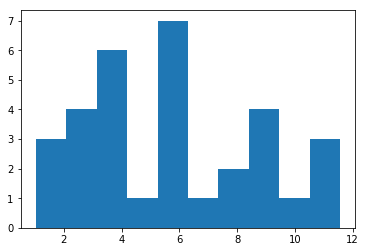

In [7]:
plt.hist(success_times)
plt.show()

In [8]:
print(len(femtimess))
#print(femtimess)
fts = [item for sublist in femtimess for item in sublist]
print(len(fts))

4
63
